# Playing with lattice generation (i.e. generating non-cubic lattices)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from polymerist.maths.lattices import generate_int_lattice

In [ ]:
from polymerist.graphics import plotutils

coords = np.array([3, 3, 3])
num_points = coords.prod()

lattice = generate_int_lattice(*coords)
plotutils.scatter_3D(lattice)

In [ ]:
A = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1/2, 1/2, 1/np.sqrt(2)],
])
shear = lattice @ A
plotutils.scatter_3D(shear)

In [ ]:
dims = np.tile(coords, reps=(num_points, 1))
FCC = np.mod(shear, dims-0.99)
plotutils.scatter_3D(FCC)

# Playing with rich progress

In [ ]:
from rich.progress import track, Progress
from time import sleep

with Progress() as progress:

    task1 = progress.add_task("[red]Downloading...", total=1000)
    task2 = progress.add_task("[green]Processing...", total=1000)
    task3 = progress.add_task("[cyan]Cooking...", total=1000)

    while not progress.finished:
        progress.update(task1, advance=0.5)
        progress.update(task2, advance=0.3)
        progress.update(task3, advance=0.9)
        sleep(0.02)

In [ ]:
import time
import random
from rich.progress import (
    BarColumn,
    Progress,
    SpinnerColumn,
    TaskProgressColumn,
    TimeElapsedColumn,
    TimeRemainingColumn,
)

def process(chunks):
    for chunk in chunks:
        time.sleep(0.1)
        yield chunk

chunks = [random.randint(1,20) for _ in range(100)]

progress_columns = (
    SpinnerColumn(),
    "[progress.description]{task.description}",
    BarColumn(),
    TaskProgressColumn(),
    "Elapsed:",
    TimeElapsedColumn(),
    "Remaining:",
    TimeRemainingColumn(),
)

with Progress(*progress_columns) as progress_bar:
    task = progress_bar.add_task("[blue]Downloading...", total=sum(chunks))
    for chunk in process(chunks):
        progress_bar.update(task, advance=chunk)

In [ ]:
import random
import time

from rich.live import Live
from rich.table import Table


def generate_table() -> Table:
    """Make a new table."""
    table = Table()
    table.add_column("ID")
    table.add_column("Value")
    table.add_column("Status")

    for row in range(random.randint(2, 6)):
        value = random.random() * 100
        table.add_row(
            f"{row}", f"{value:3.2f}", "[red]ERROR" if value < 50 else "[green]SUCCESS"
        )
    return table


with Live(generate_table(), refresh_per_second=4) as live:
    for _ in range(40):
        time.sleep(0.4)
        live.update(generate_table())

In [ ]:
from dataclasses import dataclass
from rich.console import Console, ConsoleOptions, RenderResult
from rich.table import Table

@dataclass
class Student:
    id: int
    name: str
    age: int
    def __rich_console__(self, console: Console, options: ConsoleOptions) -> RenderResult:
        yield f"[b]Student:[/b] #{self.id}"
        my_table = Table("Attribute", "Value")
        my_table.add_row("name", self.name)
        my_table.add_row("age", str(self.age))
        yield my_table

# Playing with cubic/octahedral symmetry groups

In [60]:
import numpy as np
from polymerist.graphics.plotutils import scatter_3D
from polymerist.maths.lattices import generate_int_lattice

d : int = 6

# produce integer lattice
dims = np.array([d, d, d])
num_points = dims.prod()
lattice = generate_int_lattice(*dims)

# sort lexicographically
order = np.lexsort(lattice.T)
lattice = lattice[order]

# determine even and odd positions after sorting
index_is_odd = lattice.sum(axis=1) % 2
index_is_odd = index_is_odd.astype(bool)

# center lattice at the origin
COM = lattice.mean(axis=0)
lattice = lattice - COM # sort lexicographically and translate center of grid to origin

# print(order, lattice[order])

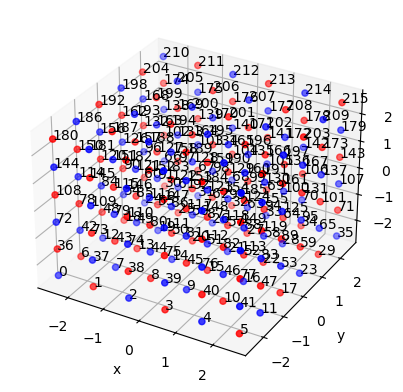

In [61]:
import matplotlib.pyplot as plt

alternate : bool = not False
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

if alternate:
    ax.scatter(*lattice[ index_is_odd].T, color='r')
    ax.scatter(*lattice[~index_is_odd].T, color='b')
else:
    ax.scatter(*lattice.T, color='r')

labels = np.lexsort(lattice.T)
for i, coords in zip(labels, lattice):
    ax.text(*coords, str(i))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [62]:
from typing import Generator, Iterable
from itertools import permutations, product as cartesian_product
from polymerist.maths.combinatorics.permutations import Permutation, Cycle
from scipy.spatial.transform import Rotation, Slerp


def sign_alternations(n : int) -> Generator[tuple[int, int, int], None, None]:
    '''Generate every possible n-tuple containing either 1 or -1'''
    for signs in cartesian_product(*([1, -1] for _ in range(n))):
        yield signs

def orthogonal_basis_transforms(n : int=3) -> Generator[np.ndarray, None, None]:
    '''Generate all matrices in n-dimensions which permute or invert the standard basis vectors'''
    for signs in sign_alternations(n):
        matr = np.diag(signs)
        for perm in Permutation.symmetric_group(n):
            yield matr @ perm.matrix

def interpolate_linear_transformation(trans : np.ndarray, n_frames : int=10) -> np.ndarray:
    '''Accepts a linear transformation matrix (of size MxN) and a number of frames F
    Returns an FxMxN array containing uniforms "steps" between the identity and the desired transformation'''
    I = Rotation.identity()
    rot = Rotation.from_matrix(trans)
    full_rot = Rotation.concatenate([I, rot])
    interpolator = Slerp(np.linspace(0, 1, num=len(full_rot), dtype=int), full_rot)

    return interpolator(np.linspace(0, 1, num=n_frames)).as_matrix()

In [69]:
from collections import defaultdict

perms  = {}
all_cycles = {}

orbits = defaultdict(set)
stabilizers = defaultdict(list)

init_order = np.lexsort(lattice.T)
group_matrices = [el for el in orthogonal_basis_transforms(3)]
for i, trans in enumerate(group_matrices):
    new = lattice @ trans
    perms[i]      = perm   = Permutation(*np.lexsort(new.T))
    all_cycles[i] = cycles = perm.to_cycles(canonicalize=False)
    
    for cycle in cycles:
        if len(cycle) == 1:
            point_idx = cycle[0] # get the one element in the singleton cycle
            stabilizers[point_idx].append(trans)

        for point_idx in cycle:
            orbits[point_idx].update(cycle)

unique_orbits = set(tuple(sorted(orbit)) for orbit in orbits.values())
sum(len(i) for i in unique_orbits) == num_points

True

In [70]:
stab_sizes = {k : len(v) for k, v in stabilizers.items()}
for i in unique_orbits:
    print([stab_sizes[j] for j in i])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[6, 6, 6, 6, 6, 6, 6, 6]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6]


## Visualize all symmetry actions as GIFs

In [71]:
from pathlib import Path
from math import ceil
from matplotlib.animation import FuncAnimation, ArtistAnimation, writers
from rich.progress import track


n_frames = 20

dir = Path('gif_frames')
dir.mkdir(exist_ok=True)

ax_max = ceil(d / 2)
ax_min = -ax_max

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.autoscale(False)

def update(frame_no : int):
    partial_rot = keyframes[frame_no, :, :]
    latt_pos = lattice @ partial_rot

    ax.clear()
    ax.set(xlim3d=(ax_min, ax_max), xlabel='X')
    ax.set(ylim3d=(ax_min, ax_max), ylabel='Y')
    ax.set(zlim3d=(ax_min, ax_max), zlabel='Z')

    return ax.scatter(*latt_pos.T)

for i, trans in track(enumerate(group_matrices), total=len(group_matrices), description='Visualizing symmetry group actions...'):
    keyframes = interpolate_linear_transformation(trans, n_frames=n_frames)
    ani = FuncAnimation(fig=fig, func=update, frames=len(keyframes), interval=10)
    ani.save(dir/f'symmetry_{i+1}.gif', writer='pillow')
    plt.close(fig)

Output()

# Developing maximally-symmetric lattice population algorithm

In [ ]:
from polymerist.graphics.plotutils import presize_subplots

max_n_atoms : int = 10_000

records = {}
for mol_name, n_atoms in counts.items():
    n_oligomers = max_n_atoms // n_atoms
    cubic_lattice_dim = np.ceil(n_oligomers**(1/3))

    lattice_info = {
        'n_atoms'  : n_atoms,
        'n_oligomers' : n_oligomers,
        'occupancy' : n_oligomers / cubic_lattice_dim**3,
        'vacancy' : cubic_lattice_dim**3 - n_oligomers,
    }
    records[mol_name] = lattice_info

df = pd.DataFrame.from_dict(records, orient='index')

fig, ax = presize_subplots(nrows=2, ncols=2, scale=10, elongation=1.0)
for colname, axis in zip(df.columns, ax.flatten()):
    heights, bins, patches = axis.hist(df[colname])
    axis.set_xlabel(colname)
    axis.set_ylabel('Counts')

plt.show()

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule
from polymerist.monomers import specification

smi = '[Br]-[C]12-[C]3(-[I])-[C]4(-[Cl])-[C]-1(-[N])-[C]1(-[I])-[C]-2(-[Cl])-[C]-3(-[N])-[C]-4-1-[Br]'
print(smi)
mol = Chem.MolFromSmiles(smi, sanitize=True)
mol = Chem.AddHs(mol)
EmbedMolecule(mol)
display(mol)

Chem.MolToMolFile(mol, 'cubane.mol')